<a href="https://colab.research.google.com/github/gimb99/PDH_BARTHOU_GONZALO/blob/develop/001_Integrador_1/GBG_001_LaboratorioIntegrador.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Laboratorio Integrador: Analizador de Tendencias en Noticias Argentinas

**Duración estimada:** 1 hora

## Contexto del Desafío

Imaginá que trabajás en un medio de comunicación y te encargan analizar automáticamente las noticias del día para identificar los temas más mencionados, las personalidades más relevantes y las conexiones entre diferentes entidades.

**Tu misión es** construir un sistema en Python que extraiga noticias de la web y las procese utilizando técnicas de Procesamiento del Lenguaje Natural (PLN).

## Objetivos del Laboratorio

###Al finalizar este laboratorio, vas a poder:

- Extraer el contenido de noticias publicadas en sitios web argentinos.

- Procesar texto con la librería SpaCy para obtener información lingüística clave.

- Crear visualizaciones para representar las entidades y los temas más relevantes.

- Estructurar el código en una clase reutilizable para el análisis de noticias.

In [ ]:
# Instalamos las librerías necesarias en modo silencioso (-q)
!pip install spacy trafilatura pandas matplotlib wordcloud plotly -q
!python -m spacy download es_core_news_lg -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.6/132.6 kB 10.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 837.9/837.9 kB 15.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 315.5/315.5 kB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 274.7/274.7 kB 12.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 568.0/568.0 MB 3.2 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('es_core_news_lg')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [ ]:
# Importación de librerías
import spacy
import trafilatura
import pandas as pd
from collections import Counter
from datetime import datetime
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import plotly.graph_objects as go
from spacy import displacy

# Cargamos el modelo grande de SpaCy para español
# Este modelo incluye vectores de palabras, lo que mejora la precisión
nlp = spacy.load("es_core_news_lg")

print("Modelo y librerías cargadas con éxito.")

Modelo y librerías cargadas con éxito.


### Parte 1: Extracción de Noticias (15 minutos)

El primer paso es obtener el texto de los artículos. Vamos a usar `trafilatura`, una librería muy eficiente para extraer el contenido principal de una página web, eliminando menús, publicidades y otros elementos irrelevantes.

**Tu tarea:**

Completá la función `extraer_noticia` para que, a partir de una URL, devuelva un diccionario con el texto limpio del artículo. Es importante que contemples el manejo de errores por si una URL no es válida o no se puede procesar.

In [ ]:
def extraer_noticia(url):
    """
    Extrae el contenido de una noticia desde su URL.

    Args:
        url (str): La URL completa del artículo de la noticia.

    Returns:
        dict: Un diccionario con 'url', 'texto' y 'fecha_extraccion',
              o None si ocurre un error.
    """
    try:
        # 1. Usá trafilatura para descargar y extraer el contenido.
        # El resultado de fetch_url es un string con el HTML.
        descargado = trafilatura.fetch_url(url)

        # 2. Extraé el texto principal del HTML.
        texto = trafilatura.extract(descargado)

        if texto:
            return {
                'url': url,
                'texto': texto,
                'fecha_extraccion': datetime.now().strftime("%Y-%m-%d %H:%M")
            }
        else:
            print(f"Advertencia: No se pudo extraer texto de {url}")
            return None
    except Exception as e:
        print(f"Error procesando {url}: {e}")
        return None

# --- URLs de ejemplo ---
# IMPORTANTE: Reemplazá estas URLs genéricas con URLs de artículos específicos.
# Por ejemplo: "https://www.pagina12.com.ar/economia/..."
urls_noticias = [
    "https://www.pagina12.com.ar/584875-cientificos-crean-yogures-untables-y-postres-con-desechos-in",
    "https://www.pagina12.com.ar/691528-descubren-un-planeta-demasiado-masivo-para-su-estrella",
    "https://www.pagina12.com.ar/591599-agronomos-e-ingenieras-utilizan-canas-para-elaborar-biogas",
]

# --- Prueba de la función ---
# Descomentá y modificá la siguiente línea para probar tu función con una URL real.
url_test = "https://www.pagina12.com.ar/584875-cientificos-crean-yogures-untables-y-postres-con-desechos-in"
noticia = extraer_noticia(url_test)
if noticia:
  fecha = noticia['fecha_extraccion']
  print(f"Texto extraído ({len(noticia['texto'])} caracteres):")
  print("Fecha de extracción: ", fecha)
  print(noticia['texto'][:300] + "...") # Mostramos los primeros 300 caracteres

Texto extraído (4787 caracteres):
Fecha de extracción:  2025-08-28 23:15
Investigadores de la Universidad Nacional del Litoral (UNL) desarrollan quesos untables, yogures y postres derivados del lactosuero, un subproducto líquido que se forma durante la producción de queso que tradicionalmente es desechado. La iniciativa busca aprovechar sus propiedades nutricionales y pe...


###Parte 2: Análisis de Texto con SpaCy (20 minutos)

Una vez que tenemos el texto, el siguiente paso es analizarlo. Vamos a encapsular la lógica de análisis en una clase `AnalizadorNoticia` para mantener el código organizado y reutilizable.

**Tu tarea:**

Completá los métodos de la clase `AnalizadorNoticia`. Esta clase recibirá el texto de una noticia y, usando SpaCy, deberá ser capaz de:

- Procesar el texto para crear un objeto `Doc`.

- Extraer entidades nombradas (personas, organizaciones, lugares).

- Calcular estadísticas básicas sobre el texto.

- Identificar los verbos más utilizados.

In [ ]:
class AnalizadorNoticia:
    def __init__(self, texto, nlp_model):
        """
        Inicializa el analizador con un texto y un modelo de SpaCy cargado.

        Args:
            texto (str): El texto de la noticia a analizar.
            nlp_model: Un modelo de SpaCy ya cargado.
        """
        self.texto_original = texto
        self.nlp = nlp_model
        # 1. Procesá el texto con el modelo de SpaCy para crear el objeto 'doc'.
        self.doc = self.nlp(texto)

    def obtener_entidades(self):
        """
        Extrae y clasifica las entidades nombradas del texto.

        Returns:
            dict: Un diccionario con listas de entidades agrupadas por tipo.
        """
        entidades = { 'PERSONAS': [], 'ORGANIZACIONES': [], 'LUGARES': [], 'OTROS': [] }

        # 2. Iterá sobre las entidades detectadas en self.doc.ents
        for ent in self.doc.ents:
            # Usá ent.label_ para identificar el tipo de entidad
            if ent.label_ == 'PER':
                entidades['PERSONAS'].append(ent.text)
            elif ent.label_ == 'ORG':
                entidades['ORGANIZACIONES'].append(ent.text)
            elif ent.label_ == 'LOC':
                entidades['LUGARES'].append(ent.text)
            else:
                entidades['OTROS'].append(ent.text)

        return entidades

    def obtener_verbos_principales(self, n=10):
        """
        Encuentra los 'n' verbos más frecuentes en el texto.

        Args:
            n (int): El número de verbos a devolver.

        Returns:
            list: Una lista de tuplas (verbo_lematizado, frecuencia).
        """
        # 3. Filtrá los tokens que son verbos (token.pos_ == "VERB")
        #    y obtené su forma base o lema (token.lemma_).
        verbos = [token.lemma_ for token in self.doc if token.pos_ == "VERB"]

        # 4. Usá Counter para contar la frecuencia de cada verbo.
        frecuencias = Counter(verbos)

        return frecuencias.most_common(n)

    def obtener_estadisticas(self):
        """
        Calcula estadísticas descriptivas básicas del texto.

        Returns:
            dict: Un diccionario con las principales estadísticas.
        """
        # 5. Calculá las siguientes métricas:
        total_tokens = len(self.doc)
        total_oraciones = len(list(self.doc.sents))
        palabras_unicas = len(set(token.text for token in self.doc if token.is_alpha))

        estadisticas = {
            'total_tokens': total_tokens,
            'total_oraciones': total_oraciones,
            'palabras_unicas': palabras_unicas,
            'longitud_promedio_oracion': total_tokens / total_oraciones if total_oraciones > 0 else 0
        }

        return estadisticas

    def extraer_frases_con_entidad(self, nombre_entidad):
        """
        (BONUS) Extrae todas las oraciones que mencionan una entidad específica.

        Args:
            nombre_entidad (str): El nombre de la entidad a buscar.

        Returns:
            list: Una lista de strings, donde cada string es una oración que contiene la entidad.
        """
        oraciones = []
        # 6. Iterá sobre las oraciones y verificá si el texto de la entidad está presente.
        for sent in self.doc.sents:
            if nombre_entidad in sent.text:
                oraciones.append(sent.text)

        return oraciones

# --- Prueba de la clase ---
texto_prueba = """
El presidente Javier Milei estuvo el martes en la provincia de Santa Fe para inaugurar una nueva planta de procesamiento de soja.
La compañía AgroTech Argentina anunció una inversión de 80 millones de dólares.
Mariana López, gerente general, explicó que el proyecto generará 300 puestos de trabajo.
"""

texto_prueba = noticia['texto']

analizador_prueba = AnalizadorNoticia(texto_prueba, nlp)
print("--- ENTIDADES ---")
print(analizador_prueba.obtener_entidades())
print("\n--- VERBOS PRINCIPALES ---")
print(analizador_prueba.obtener_verbos_principales())
print("\n--- ESTADÍSTICAS ---")
print(analizador_prueba.obtener_estadisticas())

--- ENTIDADES ---
{'PERSONAS': ['Sergio Rozycki', 'Desarrollo Social'], 'ORGANIZACIONES': ['Universidad Nacional del Litoral', 'Instituto de Tecnología de Alimentos', 'ITA', 'Rozycki', 'Innovar', 'Leche', 'Productos Lácteos', 'ITA', 'Rozycki', 'Universidad Nacional de Rosario'], 'LUGARES': ['UNL', 'Facultad de Ingeniería Química', 'UNL'], 'OTROS': ['La iniciativa busca aprovechar sus propiedades nutricionales y permite una salida comercial', 'Sin embargo', 'Como', 'El almacenamiento y la estabilización de este líquido para su uso posterior', 'Por eso', 'La iniciativa', 'De esta manera', 'Tecnología contra el Hambre', 'Tecnología e Innovación de la Nación']}

--- VERBOS PRINCIPALES ---
[('desarrollar', 2), ('formar', 2), ('buscar', 2), ('aprovechar', 2), ('permitir', 2), ('reducir', 2), ('gestionar', 2), ('contener', 2), ('encontrar', 2), ('transformar', 2)]

--- ESTADÍSTICAS ---
{'total_tokens': 821, 'total_oraciones': 30, 'palabras_unicas': 353, 'longitud_promedio_oracion': 27.3666666

###Parte 3: Visualización de Resultados (20 minutos)

Un buen análisis se comunica de forma efectiva. Las visualizaciones son clave para mostrar patrones y resultados de manera clara.

**Tu tarea:**

Implementá funciones para crear dos tipos de visualizaciones:

- Una nube de palabras que muestre los términos más relevantes del texto (excluyendo palabras comunes o stopwords).

- Un gráfico de barras que muestre la frecuencia de las entidades más mencionadas.

--- NUBE DE PALABRAS (TEXTO DE PRUEBA) ---


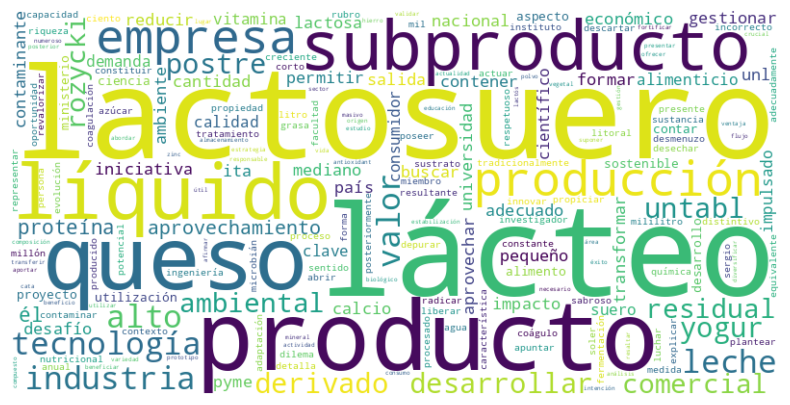


--- GRÁFICO DE ENTIDADES (TEXTO DE PRUEBA) ---


In [ ]:
def crear_nube_palabras(doc_procesado):
    """
    Crea y muestra una nube de palabras a partir de un documento de SpaCy.

    Args:
        doc_procesado: El objeto Doc resultado de procesar un texto con SpaCy.
    """
    # 1. Extraé solo palabras relevantes: que no sean stopwords, ni puntuación,
    #    y que sean alfabéticas. Usá su lema para agrupar palabras (ej: "correr", "corrió" -> "correr").
    palabras_relevantes = [
        token.lemma_.lower() for token in doc_procesado
        if not token.is_stop and not token.is_punct and token.is_alpha
    ]

    texto_limpio = ' '.join(palabras_relevantes)

    # 2. Generá la nube de palabras si hay texto disponible.
    if texto_limpio:
        wordcloud = WordCloud(
            width=800, height=400, background_color='white', collocations=False
        ).generate(texto_limpio)

        plt.figure(figsize=(10, 5))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis("off")
        plt.show()
    else:
        print("No hay suficientes palabras relevantes para generar la nube.")


def visualizar_entidades_mas_comunes(entidades_dict, n=10):
    """
    Crea un gráfico de barras con las 'n' entidades más frecuentes.

    Args:
        entidades_dict (dict): Diccionario de entidades, como el que devuelve obtener_entidades().
        n (int): Número de entidades a mostrar.
    """
    # 3. Juntá todas las entidades en una sola lista y contá sus frecuencias.
    todas_entidades = (
        entidades_dict['PERSONAS'] +
        entidades_dict['ORGANIZACIONES'] +
        entidades_dict['LUGARES']
    )
    frecuencias = Counter(todas_entidades)
    entidades_comunes = frecuencias.most_common(n)

    if not entidades_comunes:
        print("No se encontraron entidades para visualizar.")
        return

    # 4. Prepará los datos para el gráfico y visualizalos.
    entidades, counts = zip(*entidades_comunes)

    fig = go.Figure([go.Bar(x=list(counts)[::-1], y=list(entidades)[::-1], orientation='h')])
    fig.update_layout(
        title=f'Top {n} Entidades más Mencionadas',
        xaxis_title='Frecuencia',
        yaxis_title='Entidad'
    )
    fig.show()

# --- Prueba de las visualizaciones ---
# Usamos el analizador de prueba creado anteriormente
print("--- NUBE DE PALABRAS (TEXTO DE PRUEBA) ---")
crear_nube_palabras(analizador_prueba.doc)

print("\n--- GRÁFICO DE ENTIDADES (TEXTO DE PRUEBA) ---")
visualizar_entidades_mas_comunes(analizador_prueba.obtener_entidades())

### Desafío Final: Integración en un Pipeline (10 minutos)

Ahora, vamos a unir todas las piezas. El objetivo es crear una clase `AnalizadorTendencias` que pueda tomar una lista de URLs, procesarlas todas y generar un reporte consolidado.

**Tu tarea:**

Completá la clase `AnalizadorTendencias`. Esta debe orquestar todo el flujo de trabajo:

- Extraer el contenido de cada URL.

- Crear un objeto AnalizadorNoticia para cada una.

- Generar un reporte agregado con las entidades y verbos más comunes de todas las noticias.

In [ ]:
class AnalizadorTendencias:
    def __init__(self, lista_urls):
        self.urls = lista_urls
        self.noticias_data = [] # Para guardar los datos extraídos
        self.analizadores = []  # Para guardar los objetos AnalizadorNoticia
        self.nlp = spacy.load("es_core_news_lg")

    def procesar_todas(self):
        """
        Orquesta la extracción y el análisis de todas las URLs.
        """
        print(f"Iniciando procesamiento de {len(self.urls)} URLs...")
        for url in self.urls:
            # 1. Extraé la noticia
            noticia = extraer_noticia(url)
            if noticia:
                self.noticias_data.append(noticia)
                # 2. Creá un analizador para la noticia y guardalo
                analizador = AnalizadorNoticia(noticia['texto'], self.nlp)
                self.analizadores.append(analizador)
        print("Procesamiento completado.")

    def generar_reporte_agregado(self, n=15):
        """
        Genera un reporte consolidado de todas las noticias procesadas.
        """
        if not self.analizadores:
            print("No hay noticias procesadas para generar un reporte.")
            return

        # 3. Agregá todas las entidades y verbos de todos los analizadores
        todas_las_entidades = {'PERSONAS': [], 'ORGANIZACIONES': [], 'LUGARES': [], 'OTROS': []}
        todos_los_verbos = []

        for analizador in self.analizadores:
            entidades = analizador.obtener_entidades()
            for tipo, lista in entidades.items():
                todas_las_entidades[tipo].extend(lista)

            verbos = [verbo for verbo, freq in analizador.obtener_verbos_principales(n=50)]
            todos_los_verbos.extend(verbos)

        print(f"\n--- REPORTE AGREGADO DE {len(self.analizadores)} NOTICIAS ---")

        # 4. Visualizá las entidades más comunes de todo el corpus
        print("\n--- ENTIDADES MÁS COMUNES (TODAS LAS NOTICIAS) ---")
        visualizar_entidades_mas_comunes(todas_las_entidades, n=n)

        # 5. Mostrá los verbos más comunes de todo el corpus
        print("\n--- VERBOS MÁS COMUNES (TODAS LAS NOTICIAS) ---")
        frecuencias_verbos = Counter(todos_los_verbos)
        print(frecuencias_verbos.most_common(n))


# --- EJECUCIÓN DEL PIPELINE COMPLETO ---
# Asegurate de que la lista 'urls_noticias' contenga URLs de artículos válidos
# pipeline = AnalizadorTendencias(urls_noticias)
# pipeline.procesar_todas()
# pipeline.generar_reporte_agregado()

## Rúbrica de Evaluación Sugerida

- **Excelente (90-100%)**: Todas las funciones fueron implementadas correctamente, incluyendo el manejo de errores. Las visualizaciones son claras y el código está bien documentado. Se implementaron las funciones bonus.

- **Muy Bueno (70-89%)**: Las funciones principales están operativas. La extracción y el análisis básico se completaron. Se generaron las dos visualizaciones principales y el código está bien organizado.

- **Bueno (50-69%)**: La extracción de noticias funciona. El análisis básico con SpaCy está implementado. Se generó al menos una visualización.

- **Necesita Mejoras (<50%)**: Las funciones están incompletas, hay errores sin manejar o falta documentación clara.

---

## Ideas para Extender el Proyecto

- **Análisis de Sentimiento**: Clasificar si una oración o noticia es positiva, negativa o neutral.

- **Agrupamiento de Noticias (Clustering)**: Agrupar automáticamente noticias que hablen del mismo tema.

- **Resumen Automático**: Generar un resumen de 2 o 3 oraciones para cada artículo.

- **Crear una API**: Exponer tu analizador como una API web usando FastAPI o Flask.

- **Dashboard Interactivo**: Construir una interfaz gráfica con Streamlit o Gradio para analizar URLs en tiempo real.